In [1]:
from z3 import *
import numpy as np
import re
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Assumption, all bit-vectors are of the same size
## NOTE: It looks like we need to always have one extra bit? For the sign?
num_bits = 4
num_vars = 3
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]])) # important
g.add(ULE(0,x[0]))
g.add(ULE(x[0],3))
g.add(ULE(0,x[1]))
g.add(ULE(x[1],3))
g.add(ULE(0,x[2]))
g.add(ULE(x[2],6))
g.add(x[0] + x[1]  == x[2])

As a sanity check, we verify that the SMTproblem has a solution

In [3]:
# sanity check (optional)
solve(g)

[x11 = False,
 x01 = True,
 x20 = False,
 x10 = False,
 x00 = False,
 x21 = True,
 x02 = False,
 x03 = False,
 x13 = False,
 x12 = False,
 x22 = False,
 x0 = 2,
 x1 = 0,
 x2 = 2,
 x23 = False]


## Bit-blasting

The function below bit-blasts the problem and stores it in CNF form in the specified directory and file. The bit-blasted problem is stored in DIMACS format. This is one for the input formats that `spur` supports.

The `save_dimacs` function returns a pair with two elements. 

The first one is that number of variables in the bit-blasted problem (`num_variables`)---do not confuse this variable with `num_vars`, which is the number of variables in the original SMT problem. The resulting bit-blasted problem is a SAT problem.

The second element `variables_number` is a map `int -> Z3_VAR` that assigs a natural number to each bit-blasted variable. This map is necessary to reverse the bit-blasting process after obtaining the samples from `spur`.

In [4]:
input_dir = 'spur_input'
input_file = 'Database2.cnf'
(num_variables, variables_number) = sat.save_dimacs(g, 
                                                    f'{input_dir}/{input_file}')

Here we call `spur` using the input file created in the previous step. We instruct it to generate 10000 samples. The output samples are stored in the same directory as the input file, and the output file is named `samples_<input_file>.txt`.

In [5]:
num_samples   = 10000
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database2.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database2.cnf
Output File: spur_input/samples_Database2.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1466 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1466 MB

Sample #1 of 4 is already a complete assignment.  Continuing...
Completing sample #2 of 4 which has 4 variables unset and 1215 samples.
Completing sample #3 of 4 which has 11 variables unset and 1963 samples.
Completing sample #4 of 4 which has 8 variables unset and 1902 samples.
STAGE #2 - COMPLETE


variables (total / active / free)

The function below parses the samples generated by `spur`. It returns a matrix with coordinates (sample, bit-blasted_var) containing all generated samples. That is, each row correspond a sample, and each column contains the value of a bit-blasted variable.

For now, the function takes as input the input directory and file for `spur`. That is, the same parameters as the previous function. The function below automatically infers the name of file containing the samples generated by `spur`.

In [6]:
samples = sat.parse_spur_samples(input_dir, input_file, 
                                 num_samples, num_variables)

The function below performs an intermediate step where we create a map from z3 bit-blasted variables to their sampled values, i.e., Z3_VAR -> list[bool].

In [7]:
map_variable_values = sat.map_spur_samples_to_z3_vars(variables_number, 
                                                      num_variables,
                                                      samples)

## Reverse bit-blasting

Finally, we take the map above to reverse the bit-blasting process for each of the spur samples. The function below returns a list of dictionaries. Each dictionary contains a sample value for the SMT problem variables (i.e., reverse-bit-blasted variables). This output format is expected output for our `mcmc.sample_mh_trace` function.

The function below takes as input the map from Z3 bit-blasted variables to values, the number of generated samples, the number of varibles (**in the SMT problem**), and the number of bits of the bit-vectors of the SMT problem. We emphasize again that the number of variables in this function refers to the number of bit-vectors in the SMT problem. Do not confuse with the number of variables in the bit-blasted SAT problem.

Here we note an important requirement of this process. All bit-vectors must have the same number of bits.

In [8]:
solver_samples = sat.reverse_bit_blasting(map_variable_values, 
                                          num_samples,
                                          num_vars,
                                          num_bits)

In [9]:
solver_samples

[{'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0, 'x1': 1, 'x2': 1},
 {'x0': 0,

As a sanity check, we have created a function that checks that all generated samples satisfy the SMT problem. 

This is an optional step. Be careful when executed for a large number of samples, as it is a computationally expensive process.

In [10]:
#  sanity check (optional, heavy computation)
utils.sat_checking_samples(g, solver_samples[:10], var_list)

True

At this point, we can use the `solver_samples` to execute our Metropolis-Hastings algorithm.

We remark that the funciton call before is exactly the same as when we use Megasampler for generating samples.

In [11]:
trace = mcmc.sample_mh_trace(num_samples=num_samples, 
                             num_chains=4,
                             solver_samples=solver_samples)

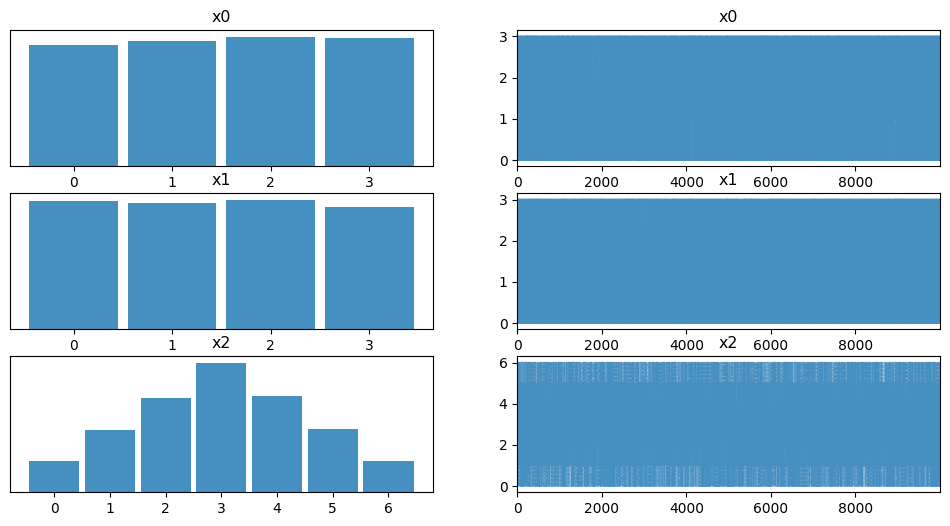

In [12]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('spur_trace_plot.png',dpi=150);

In [13]:
# Diagnosis
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.525,1.114,0.0,3.0,0.006,0.004,40170.0,40000.0,1.0
x1,1.484,1.113,0.0,3.0,0.006,0.004,40586.0,40000.0,1.0
x2,3.009,1.574,0.0,6.0,0.008,0.006,40493.0,40000.0,1.0


In [14]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.2409), (1, 0.2479), (2, 0.2566), (3, 0.2546)]
[(0, 0.0619), (1, 0.1225), (2, 0.185), (3, 0.2544), (4, 0.1898), (5, 0.1247), (6, 0.0617)]


## Non-uniform prior

Here we use the `f` parameter of our MH function to specify a prior for the variables of the SMT problem.

In particular, we consider the following very simple model

$$
x_0 \sim \mathit{Cat}(1/3, 1/3, 1/6, 1/6) ~~
x_1 \sim \mathit{U}(0,3) ~~
x_2 = x_0 + x_1
$$


In [15]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x0']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [16]:
trace = mcmc.sample_mh_trace(num_samples=num_samples, 
                             num_chains=4,
                             f = lambda s: prior(s)*likelihood(s),
                             solver_samples=solver_samples)

### Posterior analysis

We observe the in the traceplot below the effect of the prior on $x_0$. Now it is distributed as according to the categorical distribution above. As opposed to the uniform prior we used in the previous analysis.

The distribution of $x_2$ is also affected by the new prior on $x_0$.

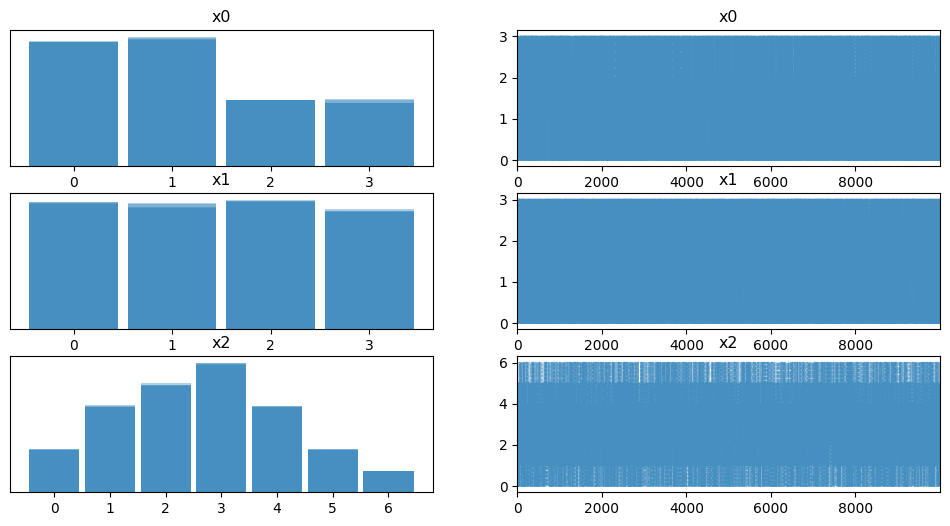

In [17]:
az.plot_trace(trace);
plt.savefig('spur_trace_plot_non_uniform.png',dpi=150);

Here we plot the probability of each outcome for $x_0$ and $x_2$

In [18]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.3247), (1, 0.333425), (2, 0.172575), (3, 0.1693)]
[(0, 0.083075), (1, 0.1672), (2, 0.20825), (3, 0.249825), (4, 0.166675), (5, 0.08325), (6, 0.041725)]


Finally, we compare the estimated values with the analytical solution to this problem.

In [19]:
real_value_x0 = [1/3, 1/3, 1/6, 1/6]
real_value_x2 = [1/12, 1/6, 5/24, 1/4, 1/6, 1/12, 1/24]

In [20]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist() - real_value_x0[i]) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist() - real_value_x2[i]) for i in range(0,7)])

[(0, -0.008633333333333326), (1, 9.166666666671208e-05), (2, 0.005908333333333349), (3, 0.0026333333333333486)]
[(0, -0.00025833333333333264), (1, 0.0005333333333333301), (2, -8.333333333335191e-05), (3, -0.00017500000000000848), (4, 8.333333333332416e-06), (5, -8.333333333332416e-05), (6, 5.833333333333385e-05)]


The error is low ($< 0.01$ for all variables and outcomes). However, I should remark that in other executions I observed errors up to 0.13...